In [16]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [17]:
# Load train & test sets
train_df = pd.read_csv("kdd_train.csv")
test_df  = pd.read_csv("kdd_test.csv")

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [18]:
train_df.info()
train_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [19]:
cat_cols = train_df.select_dtypes(include=['object']).columns

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)

    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))


In [20]:
X_train = train_df.drop("labels", axis=1)
y_train = train_df["labels"]

X_test = test_df.drop("labels", axis=1)
y_test = test_df["labels"]


In [21]:
iso = IsolationForest(contamination=0.02, random_state=42)

mask = iso.fit_predict(X_train) == 1  # keep normal points only

X_train = X_train[mask]
y_train = y_train[mask]

print("Training size after removing outliers:", X_train.shape)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Training size after removing outliers: (123453, 41)


In [22]:
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.columns.difference(cat_cols)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')


# Feature Selection (keep top 30 important features)
feature_selector = SelectKBest(score_func=mutual_info_classif, k=30)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('selector', feature_selector),
    ('classifier', GaussianNB())
])


In [23]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [24]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.6687
Precision: 0.7959
Recall:    0.6687
F1 Score:  0.7053


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


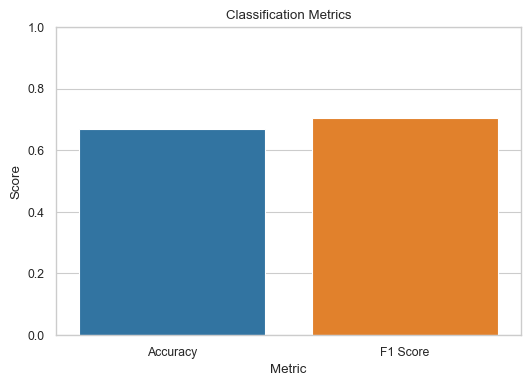

In [25]:
# Apply style
sns.set_style("whitegrid")
sns.set_context("paper")

# Compute metrics
accuracy = accuracy_score(test_df['labels'], y_pred)
f1 = f1_score(test_df['labels'], y_pred, average='weighted')   # weighted F1 for multiclass


# Prepare DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Value': [accuracy, f1]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title("Classification Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()
